# Examen TNS 2021-2022

## Merlin Schoose \& Simon Quesney \& Guillaume Pernin

## Evaluation
Vous serez évalué par groupe de 3 (à l'exception d'un groupe 4) lors d'une soutenance orale de 10 min lors de laquelle vous présenterez vos travaux. La présentation se fera en détaillant le notebook. La note sera principalement basée sur votre capacité à restituer de façon claire les notions de cours. Il est donc essentiel d'introduire dans le notebook la logique de votre travail.
La présentation se fait à trois voix et sera suivi d'une séance de questions.

Les notebooks devront être transmis par e-mail 2 jours avant la restitution orale

Les données devront mettre en oeuvre des traitements relatifs au cours TNS (donc essentiellement sur des signaux et non des méthodes de traitement d'image)

## Description de l'examen
L'examen a pour but de traiter un radargramme c'est-à-dire les données acquises par un géoradar.

Le géoradar est composé d’un châssis équipé de deux ou quatre roues sur lequel est posé en son centre l’antenne émettrice ('E') et l’antenne réceptrice ('R') très proches du sol. Il dispose également d’un odomètre qui positionne spatialement les réflexions enregistrées sous forme de signal 1D.

<img src="img/Georadar.PNG" style="height:200px">

Le géoradar émet une onde électromagnétique dans le sol sous forme de brèves impulsions à intervalle
régulier. La forme de l’impulsion émise ressemble à une ondelette de Ricker. Lorsque l’onde rencontre une discontinuité, qui se traduit par une différence de permittivité diélectrique entre deux milieux, une partie de l’énergie est réfléchie et une autre transmise. L’ensemble des ondes réfléchies parvenant jusqu’à l’antenne réceptrice est enregistré en fonction du temps.
À chaque impulsion émise, une réponse que l’on appelle trace (ou A-Scan), est stockée sous forme de signal monodimensionnel. L’opérateur, en déplaçant le géoradar va collecter un ensemble de traces qui formeront un radargramme (ou B-Scan)

<img src="img/fonctionnement_georadar2.PNG" style="height:350px">

## Les données
Pour le radargramme traité, les signaux sont enregistrés pendant 62 ns et la longueur de déplacement est de 13 m.

 ### Clutter
La configuration d’antenne avec l’émetteur et le récepteur à la fois très proche l’un de l’autre et très proche du sol implique qu’un premier enregistrement survient très rapidement, appelé onde directe. L’onde directe est très peu atténuée et par conséquent le signal enregistré a une très forte amplitude. De plus, la multiple-réverbération de l’onde avec la surface fait apparaître des formes très horizontales en arrière-plan qui se répètent verticalement sur le radargramme, appelé ringing en anglais.

### Bruit
Le bruit provient de perturbations aléatoires issues des appareils de mesures. Du fait de la très large bande passante de l’antenne, le bruit peut également apparaitre à la suite de l’enregistrement des signaux provenant des ondes électromagnétiques
dans l’air issues des antennes de radio-transmission et des appareils téléphoniques. Dans ce dernier cas des artefacts en forme de colonne apparaissent sur les données. Le bruit apparait essentiellement en fin d’enregistrement d’une trace en l’absence d’information et rehaussé par le gain appliqué en profondeur.

<img src="img/artefacts.PNG" style="height:200px">

In [1]:
import scipy.io

import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from scipy import signal

In [2]:
# Loading data
gprdata = scipy.io.loadmat('DZT_GDF001.mat')

bs = gprdata['radarDZT']
bs = bs.astype(np.int32)

In [3]:
# Helper function to properly display a radargram

def plot_radargram(bs, name):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.imshow(bs, cmap="gray")

    # Specifies x-axis values to represent the GPR's displacement over time.
    nb_x_ticks = 14
    x = np.linspace(0,13,nb_x_ticks)
    x = x.astype(np.uint32)
    ax.set_xticks(np.linspace(0,bs.shape[1],nb_x_ticks))
    ax.set_xticklabels(x)
    plt.xlabel("GPR displacement in meters")

    # Specifies y-axis values to represent the time range
    nb_y_ticks = 8
    y = np.linspace(0,62,nb_y_ticks)
    y = y.astype(np.uint32)
    ax.set_yticks(np.linspace(0,bs.shape[0],nb_y_ticks))
    ax.set_yticklabels(y)
    plt.ylabel("Time in nanoseconds before reception")

    plt.title(name)
    plt.show()

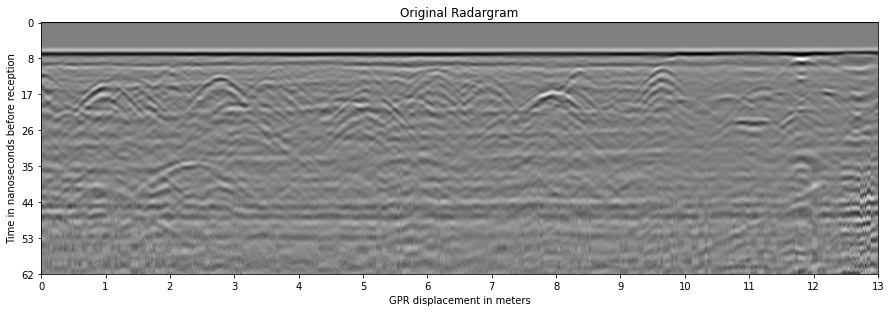

In [4]:
plot_radargram(bs, "Original Radargram")

## Analyse spectrale

On effectue des analyses spectrales horizontales et verticales en étudiant les modules des signaux pour étudier les fréquences pouvant correspondre au clutter et au bruit, et donc que l'on souhaite éliminer. On peut alors appliquer différents filtres pour épurer le signal.

In [5]:
# Helper function to apply a butterworth filter on a vertical or horizontal axis

def filter_by_butterworth(radargram, cutoff_freq, sample_rate, filter_type, vertical, order=10):
    if (vertical):
        axis=0
    else:
        axis=-1

    sos = signal.butter(order, cutoff_freq, filter_type, fs=sample_rate, output='sos')
    return signal.sosfiltfilt(sos, radargram, axis=axis)

### Analyse spectrale horizontale

On commence par une analyse spectrale horizontale du signal. On sait que les artéfacts en colonnes sont représentés par des fréquences élevés, alors que l'onde direct ainsi que le ringing sont majoritairement composées de fréquences faibles, car ces dernières varient très peu horizontalement. On effectue donc une analyse spectrale pour étudier les fréquences que l'ont souhaite éliminer.

In [6]:
# Helper function to display an horizontal sample of the signal and its spectrum

def horizontal_spectrum(signal, sample_rate, index_sample):
    spatial_samples = signal
    x = np.linspace(0,13,bs.shape[1])

    plt.figure(figsize=(15,6))

    plt.subplot(1,2,1)
    plt.title("The " + str(index_sample) + "th horizontal sample temporal signal")
    plt.xlabel("GPR displacement in meter")
    plt.plot(x, spatial_samples)

    plt.subplot(1,2,2)
    fourier_spatial = np.fft.rfft(spatial_samples)
    freq = np.fft.rfftfreq(signal.size, d=1./sample_rate)
    plt.title("The horizontal spectrum at the " + str(index_sample) + "th sample")
    plt.plot(freq[1:], np.abs(fourier_spatial[1:]))
    plt.xlabel("Horizontal frequency in m^-1")
    plt.show()

In [7]:
# Computes the horizontal sample rate (the gpr moves 13 meters in total with 1705 samples).
horizontal_sample_rate = bs.shape[1]/13

print("The horizontal sample rate is " + str(horizontal_sample_rate) + " m^-1")

The horizontal sample rate is 131.15384615384616 m^-1


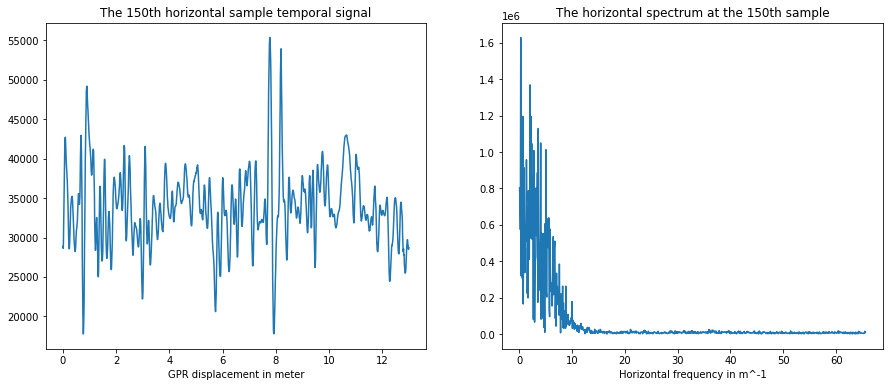

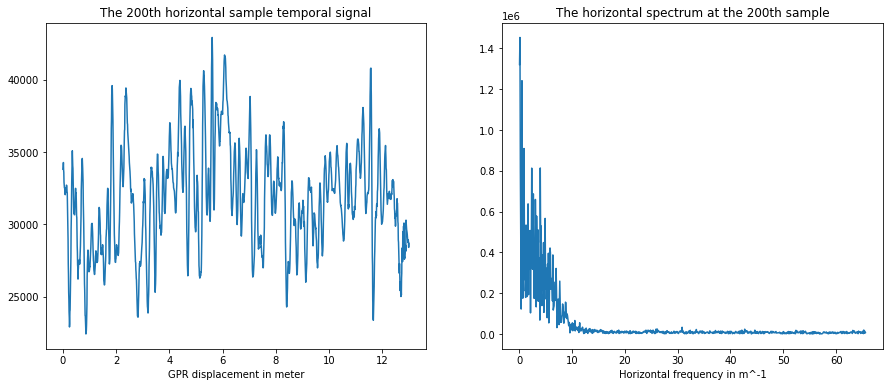

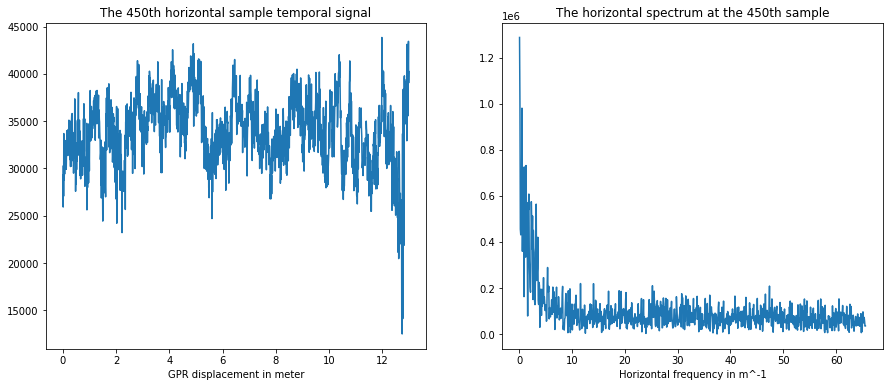

In [8]:
# Displays the horizontal spectrum for a few sample
# We can observe that the first few sample contain more useful
# information than the end samples, which are more noisy.

horizontal_spectrum(bs[150], horizontal_sample_rate, 150)
horizontal_spectrum(bs[200], horizontal_sample_rate, 200)
horizontal_spectrum(bs[450], horizontal_sample_rate, 450)

On observe que dans les zones contenant une majorité d'information que l'on souhaite conserver, les fréquences en $m^{-1}$ convergent vers $0$ aux alentours de $10$-$20$ $m^{-1}$. Au contraire, dans les zones où il y a du clutter avec des traits horizontaux, l'analyse spectrale révèle que le spectre ne converge pas vers $0$ comme dans les spectres précédents. On peut faire la supposition que ces hautes fréquences correspondent au phénomène de clutter et que nous pouvons les retirer grâce à un filtre passe-bas.

À partir de ces observations et de tests empiriques, on a pu sélectionner la limite de nos filtres, permettant d'ostraciser un maximum d'artéfacts du signal, à l'aide de filtres passe-haut et passe-bas, réuni au sein d'un filtre passe-bande final.

In [9]:
# Sets the filters limit
horizontal_low = 0.2
horizontal_high = 12

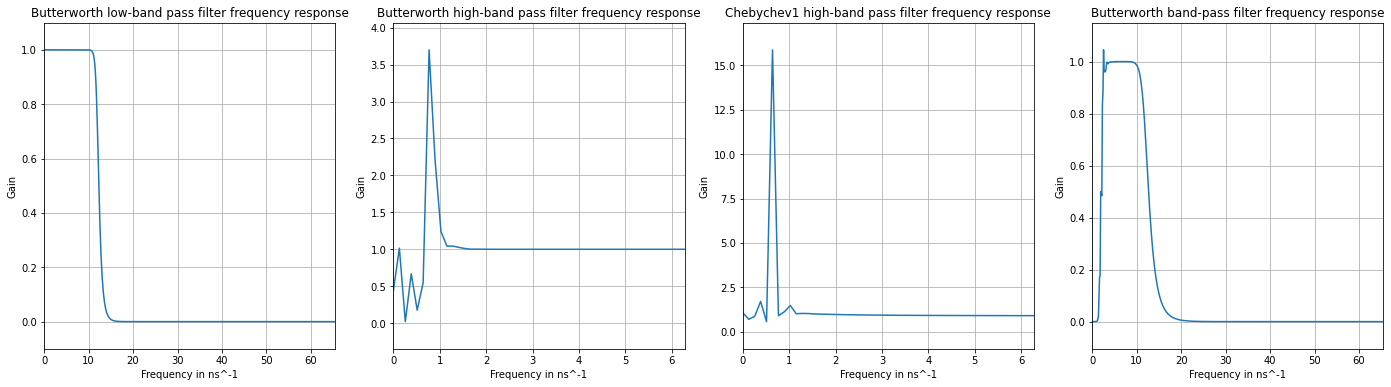

In [10]:
# Displays the Bode plot of the studied filters
plt.figure(figsize=(24,6))

plt.subplot(1,4,1)
b, a = signal.butter(20, horizontal_high, 'lp', analog=False, fs=horizontal_sample_rate)
w, h = signal.freqz(b, a)
plt.plot((horizontal_sample_rate * 0.5 / np.pi) * w, abs(h))
plt.title('Butterworth low-band pass filter frequency response')
plt.xlabel('Frequency in ns^-1')
plt.ylabel('Gain')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')

plt.subplot(1,4,2)
b, a = signal.butter(10, horizontal_low, 'hp', analog=False, fs=horizontal_sample_rate)
w, h = signal.freqz(b, a)
plt.plot((horizontal_sample_rate * 0.5 / np.pi) * w[:50], abs(h[:50]))
plt.title('Butterworth high-band pass filter frequency response')
plt.xlabel('Frequency in ns^-1')
plt.ylabel('Gain')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')

plt.subplot(1,4,3)
b, a = signal.cheby1(10, 1, horizontal_low, 'hp', analog=False, fs=horizontal_sample_rate)
w, h = signal.freqz(b, a)
plt.plot((horizontal_sample_rate * 0.5 / np.pi) * w[:50], abs(h[:50]))
plt.title('Chebychev1 high-band pass filter frequency response')
plt.xlabel('Frequency in ns^-1')
plt.ylabel('Gain')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')

plt.subplot(1,4,4)
b, a = signal.butter(9, [horizontal_low, horizontal_high], 'band', analog=False, fs=horizontal_sample_rate)
w, h = signal.freqz(b, a)
plt.plot((horizontal_sample_rate * 0.5 / np.pi) * w, abs(h))
plt.title('Butterworth band-pass filter frequency response')
plt.xlabel('Frequency in ns^-1')
plt.ylabel('Gain')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.show()

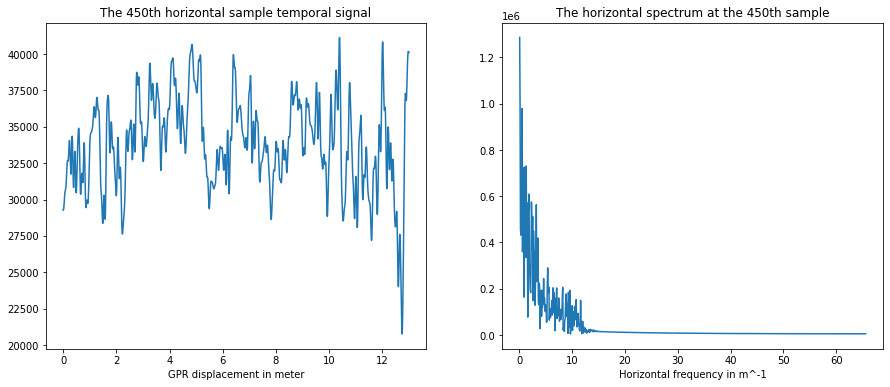

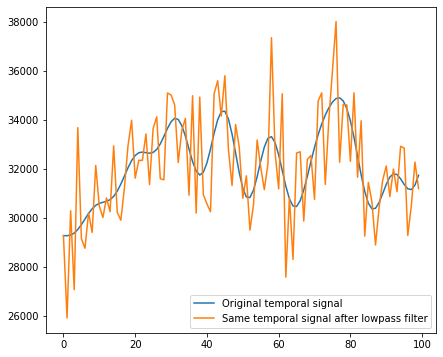

In [11]:
# Example application of a low-pass filter on a sample of the radargram

sos = signal.butter(10, horizontal_high, 'lp', fs=horizontal_sample_rate, output='sos')
filtered = signal.sosfiltfilt(sos, bs[450])
horizontal_spectrum(filtered, horizontal_sample_rate, 450)

fig, ax = plt.subplots(figsize=(7, 6))
last_value = 100
ax.plot(filtered[:last_value], label="Original temporal signal")
ax.plot(bs[450][:last_value], label="Same temporal signal after lowpass filter")
ax.legend()
plt.show()

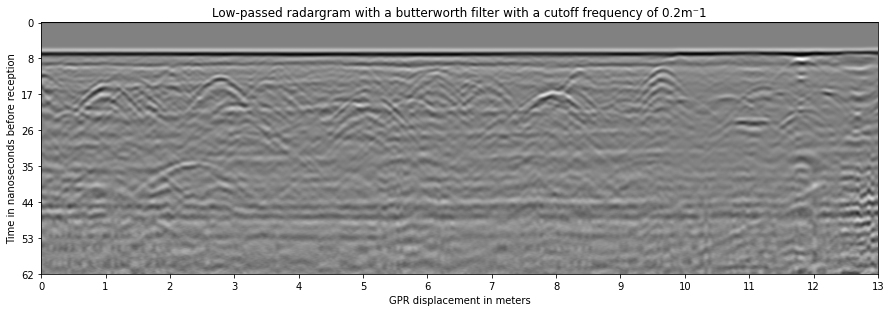

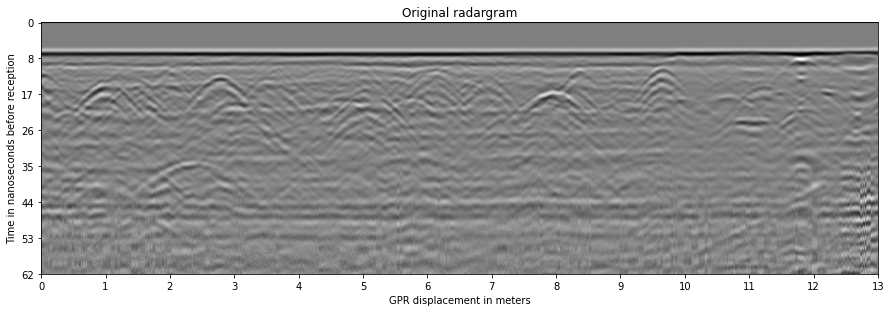

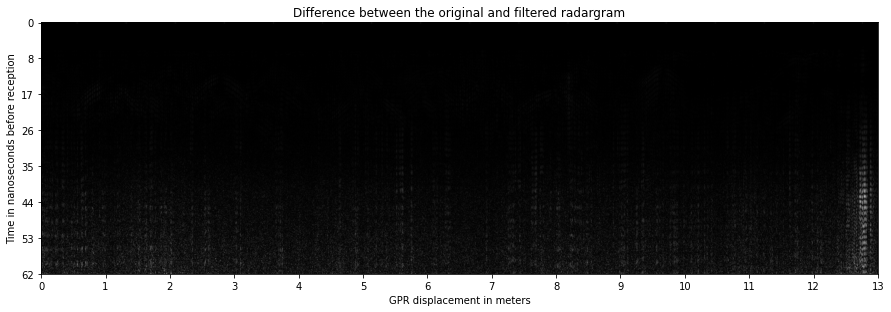

In [12]:
# Applies low-pass filter and displays the results

bs_horizontal_filtered = filter_by_butterworth(bs, horizontal_high, horizontal_sample_rate, 'lp', False)
plot_radargram(bs_horizontal_filtered, "Low-passed radargram with a butterworth filter with a cutoff frequency of " + str(horizontal_low) + "m⁻1")
plot_radargram(bs, "Original radargram")
plot_radargram(np.abs(bs - bs_horizontal_filtered), "Difference between the original and filtered radargram")

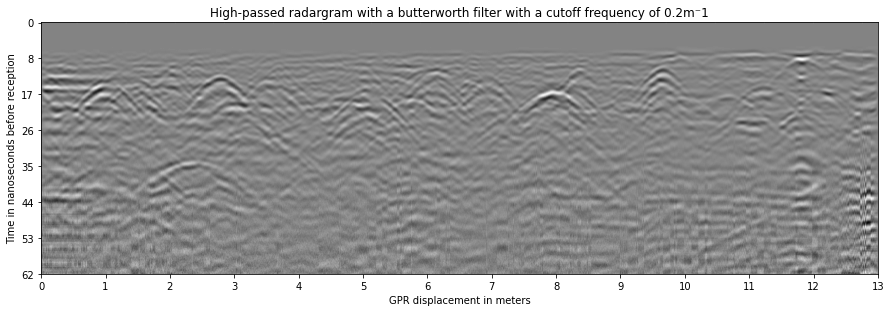

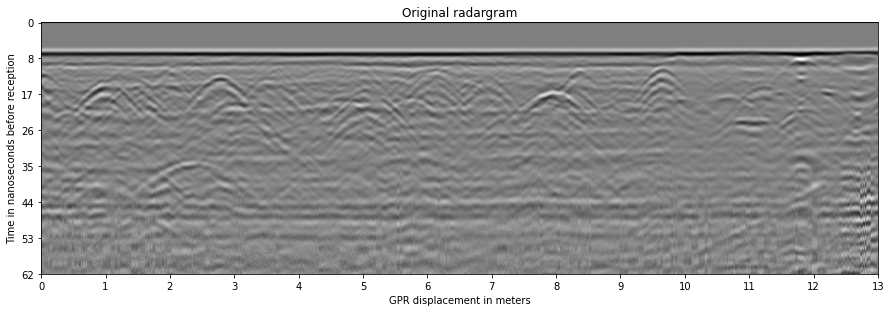

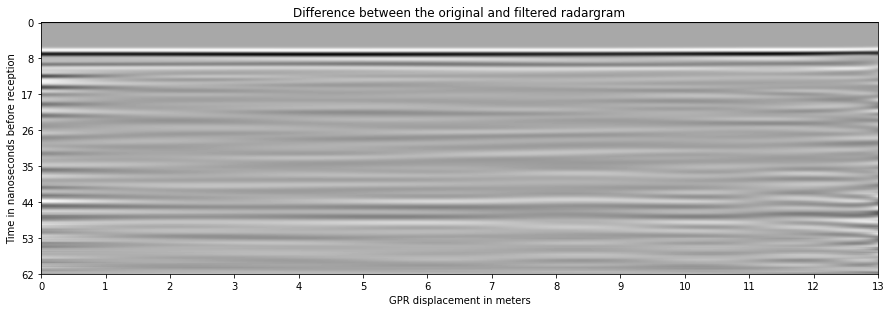

In [13]:
# Applies high-pass filter and displays the results

bs_horizontal_filtered = filter_by_butterworth(bs, horizontal_low, horizontal_sample_rate, 'hp', False)
plot_radargram(bs_horizontal_filtered, "High-passed radargram with a butterworth filter with a cutoff frequency of " + str(horizontal_low) + "m⁻1")
plot_radargram(bs, "Original radargram")
plot_radargram(np.abs(bs - bs_horizontal_filtered), "Difference between the original and filtered radargram")

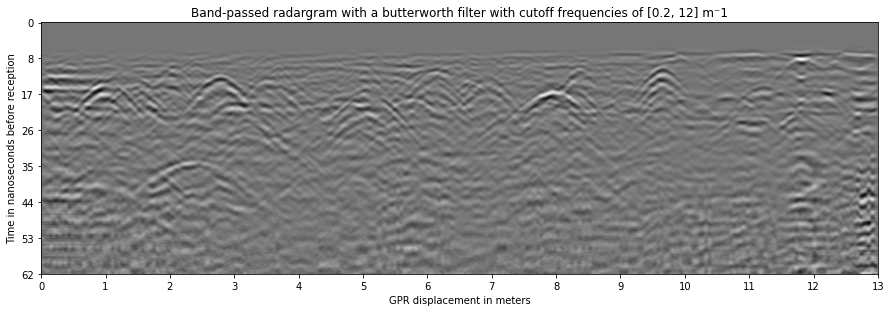

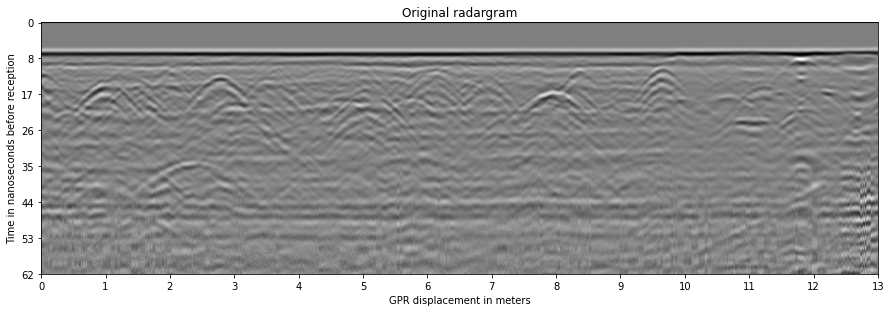

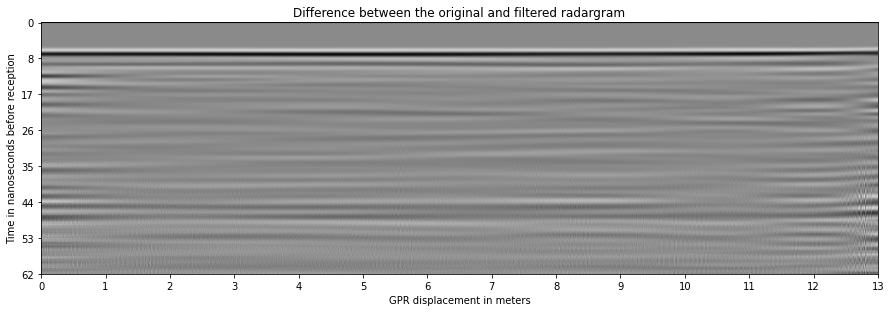

In [14]:
# Applies band-pass filter (concatenation of the previous filters) and displays the results

bs_horizontal_filtered = filter_by_butterworth(bs, [horizontal_low, horizontal_high], horizontal_sample_rate, 'band', False)
plot_radargram(bs_horizontal_filtered, "Band-passed radargram with a butterworth filter with cutoff frequencies of [" + str(horizontal_low) + ", " + str(horizontal_high) + "] m⁻1")
plot_radargram(bs, "Original radargram")
plot_radargram(np.abs(bs - bs_horizontal_filtered), "Difference between the original and filtered radargram")

## Analyse spectrale verticale

Dans un second temps, on effectue une analyse spectrale verticale, afin d'éliminer du bruit. En effet, le GPR écoute sur une plage de fréquence très large, qui doit donc être restreinte afin de ne garder que des informations utiles.

In [15]:
# Helper function to display an horizontal sample of the signal and its spectrum

def vertical_spectrum(signal, sample_rate, index_sample, index_begin=0, index_end=512):
    nb_samples = index_end - index_begin
    spatial_samples = signal[index_begin:index_end]
    x = np.linspace((index_begin/512)*62, (index_end/512)*62, nb_samples)

    plt.figure(figsize=(15,6))

    plt.subplot(1,2,1)
    plt.title("The " + str(index_sample) + "th vertical sample temporal signal")
    plt.xlabel("Time in nanoseconds before reception")
    plt.plot(x, spatial_samples)

    plt.subplot(1,2,2)
    fourier_spatial = np.fft.rfft(spatial_samples)
    freq = np.fft.rfftfreq(spatial_samples.size, d=1./sample_rate)
    plt.title("The vertical spectrum at the " + str(index_sample) + "th sample")
    plt.plot(freq[1:], np.abs(fourier_spatial[1:]))
    plt.xlabel("Vertical frequency in ns^-1")
    plt.show()

In [16]:
# Computes the vertical sample rate (the gpr gets 512 samples in 62 nanoseconds).
vertical_sample_rate = 512/62

print("The vertical sample rate is " + str(vertical_sample_rate) + " ns^-1")

The vertical sample rate is 8.258064516129032 ns^-1


In [17]:
# Sets the filters limit
vertical_low = 0.2
vertical_high = 1.0

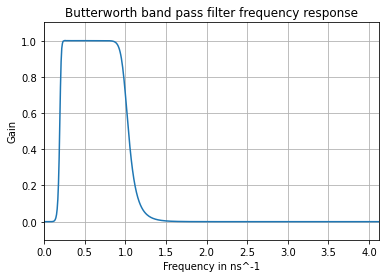

In [18]:
# Display the Bode plot of the band pass vertical filter
b, a = signal.butter(9, [vertical_low, vertical_high], 'band', analog=False, fs=vertical_sample_rate)
w, h = signal.freqz(b, a)

plt.plot((vertical_sample_rate * 0.5 / np.pi) * w, abs(h))
plt.title('Butterworth band pass filter frequency response')
plt.xlabel('Frequency in ns^-1')
plt.ylabel('Gain')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.show()

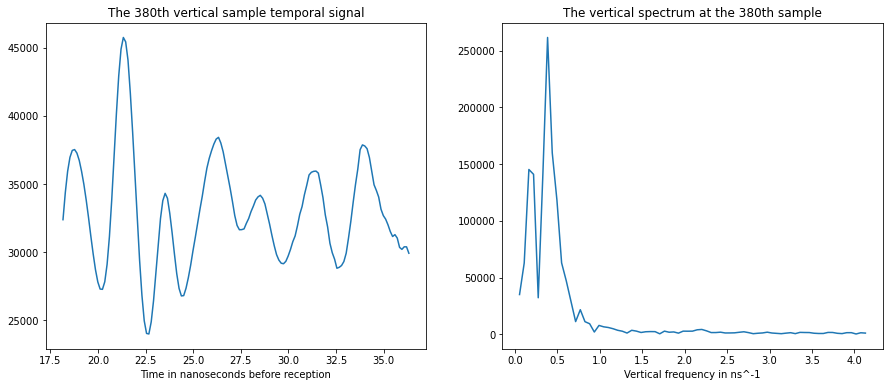

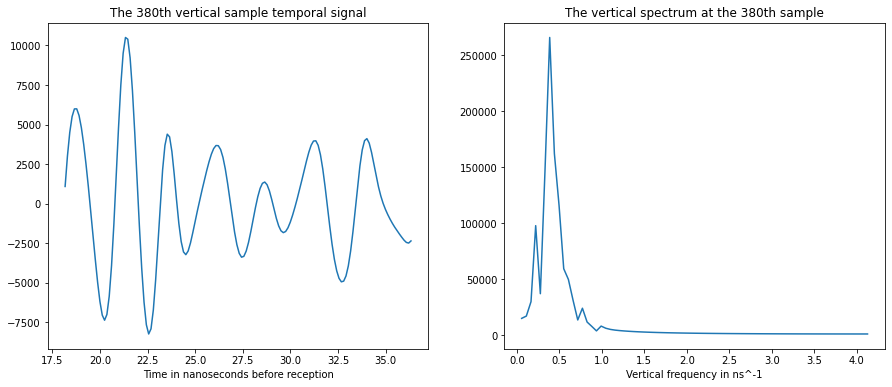

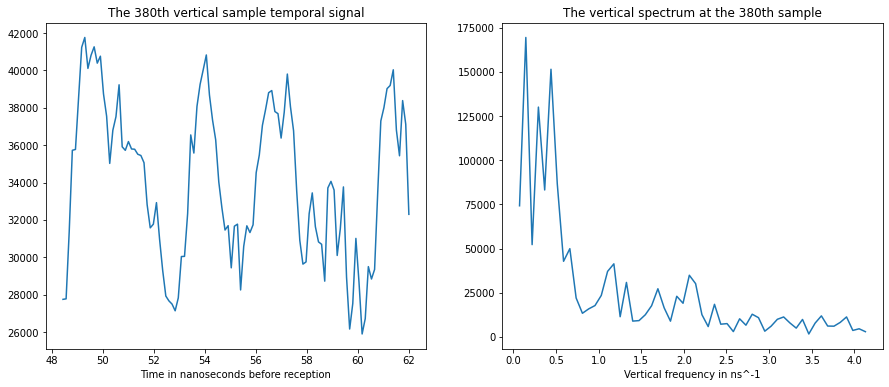

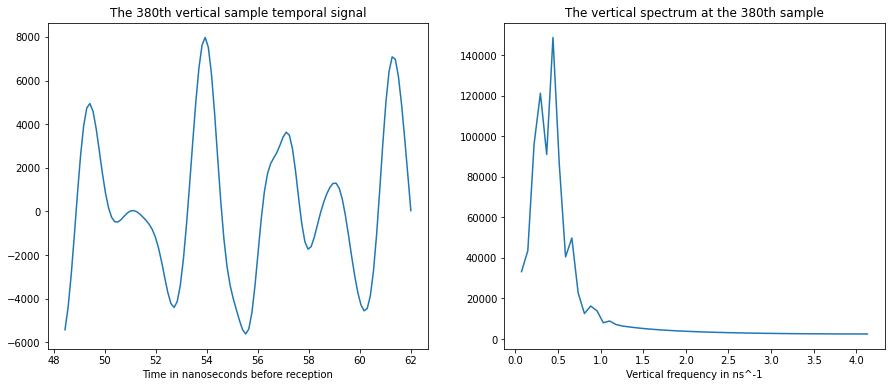

In [19]:
# Examples of applications of the filters on vertical samples

sos = signal.butter(9, [vertical_low, vertical_high], 'bp', fs=vertical_sample_rate, output='sos')
bs_trace_lowpass = signal.sosfiltfilt(sos, bs[:,380])

vertical_spectrum(bs[:,380], vertical_sample_rate, 380, 150, 300)
vertical_spectrum(bs_trace_lowpass, vertical_sample_rate, 380, 150, 300)

vertical_spectrum(bs[:,380], vertical_sample_rate, 380, 400, 512)
vertical_spectrum(bs_trace_lowpass, vertical_sample_rate, 380, 400, 512)

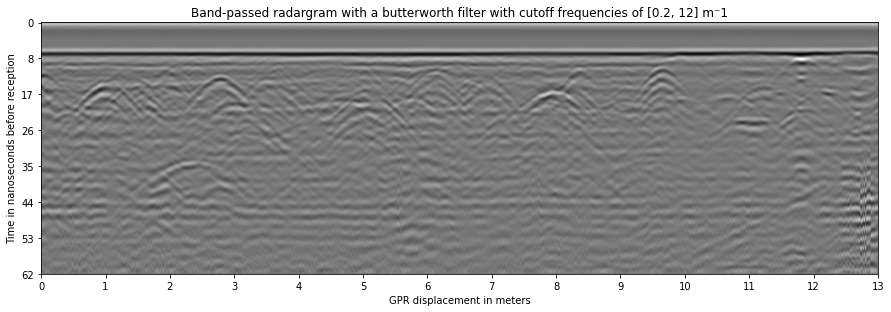

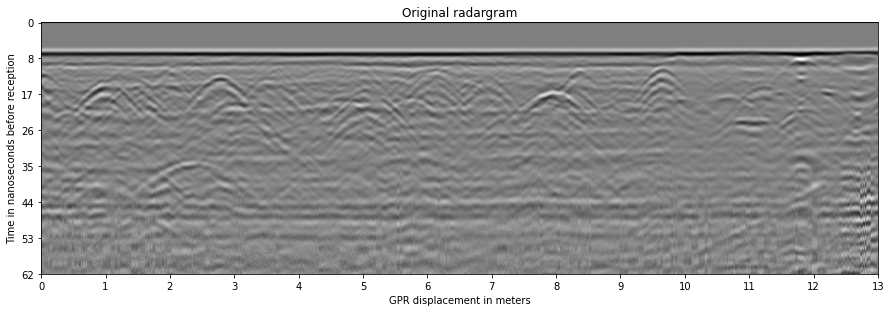

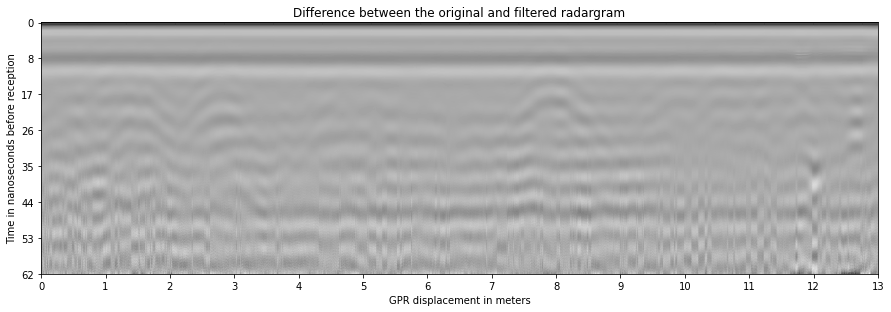

In [20]:
# Applies the final vertical band-pass filter and displays the results

bs_vertical_filtered = filter_by_butterworth(bs, [vertical_low, vertical_high], vertical_sample_rate, 'band', vertical=True, order=9)
plot_radargram(bs_vertical_filtered, "Band-passed radargram with a butterworth filter with cutoff frequencies of [" + str(horizontal_low) + ", " + str(horizontal_high) + "] m⁻1")
plot_radargram(bs, "Original radargram")
plot_radargram(np.abs(bs - bs_vertical_filtered), "Difference between the original and filtered radargram")

## [Archive] Filtrage de l'onde directe et du ringing à l'aide d'un mean filter

Une des premières solutions trouvées pour filtrer l'onde directe et le ringing était l'application d'un filtre moyen selon l'axe horizontale. Cependant, cette solution a été abandonnée car l'utilisation d'un filtre passe-haut horizontale reste plus efficace, car le filtre passe-haut va aussi se défaire du bruit de basse fréquence présent dans le bas du radargramme.

In [21]:
# Helper function to apply a mean filter.

def apply_mean(radargram):
    mean = np.mean(bs, axis=1)
    return radargram - np.repeat(np.expand_dims(mean, axis=-1), bs.shape[1], axis=1)

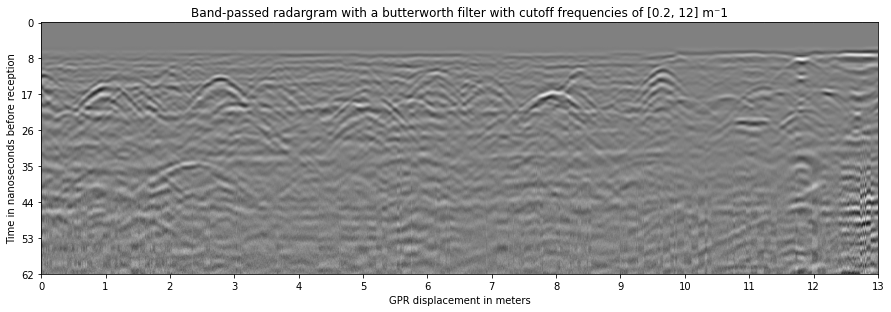

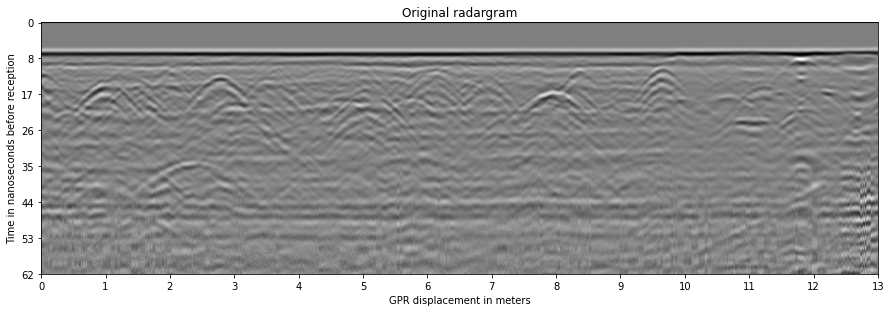

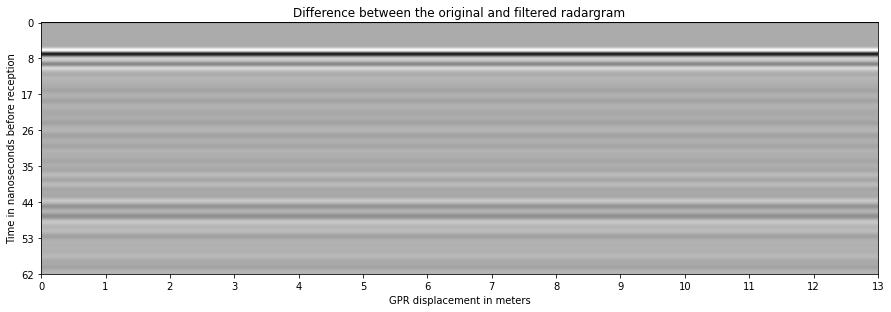

In [22]:
# Applies the mean filter and displays the results

bs_mean = apply_mean(bs)
plot_radargram(bs_mean, "Band-passed radargram with a butterworth filter with cutoff frequencies of [" + str(horizontal_low) + ", " + str(horizontal_high) + "] m⁻1")
plot_radargram(bs, "Original radargram")
plot_radargram(np.abs(bs - bs_mean), "Difference between the original and filtered radargram")

## Application de toutes les solutions
On va maintenant appliquer toutes les méthodes que l'on a pu voir jusqu'à présent.

###  [Archive] Ancienne solution
On appliquait deux filtres passe-bas verticalement et horizontalement et on enlevait la moyenne ensuite.

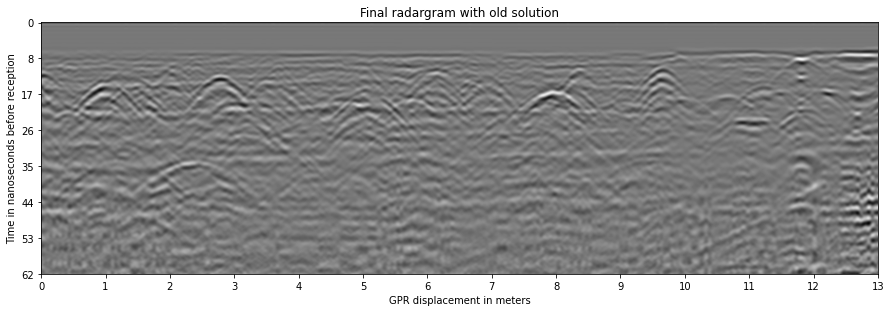

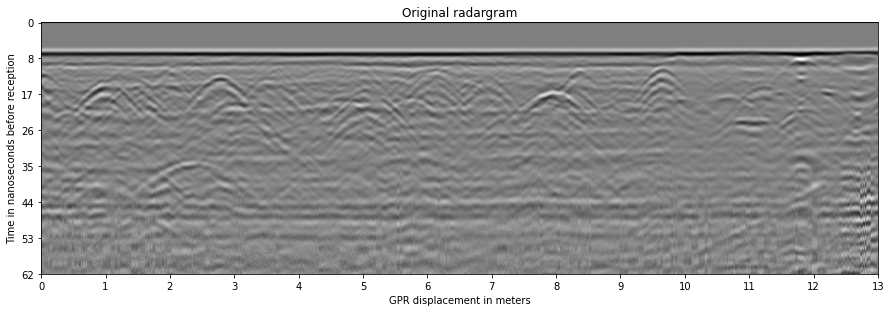

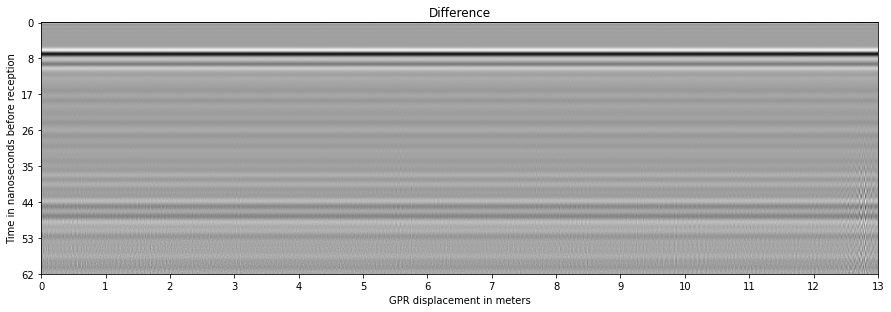

In [23]:
# Displays the radargram with the two low-pass filters and the mean removal

bs_vertical_filtered = filter_by_butterworth(bs, vertical_high , vertical_sample_rate, 'lp', vertical=True, order=9)
bs_horizontal_filtered = filter_by_butterworth(bs_vertical_filtered, horizontal_high, horizontal_sample_rate, 'lp', vertical=False)
bs_filtered_old = apply_mean(bs_horizontal_filtered)
plot_radargram(bs_filtered_old, "Final radargram with old solution")
plot_radargram(bs, "Original radargram")
plot_radargram(np.abs(bs - bs_filtered_old), "Difference")

### Solution choisie

Pour retirer le clutter, le ringing, le bruit et les artefacts en colonnes, on applique deux filtres passe-bandes de Butterworth verticalement et horizontalement.

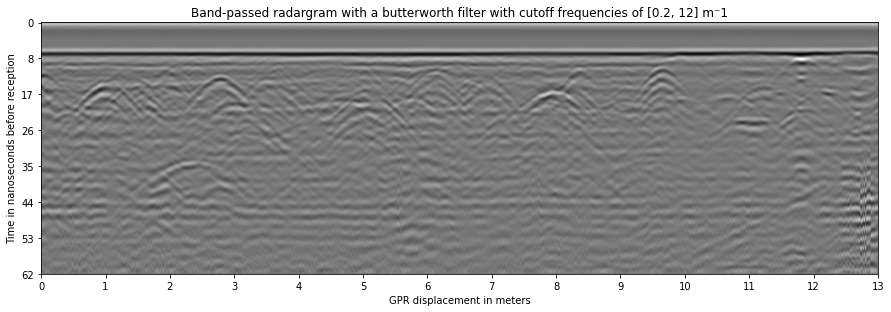

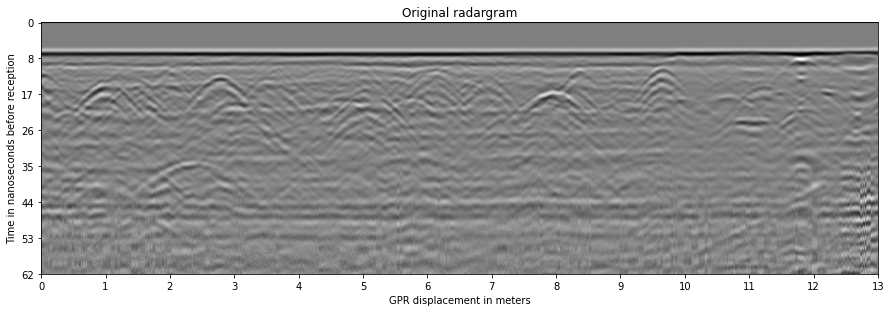

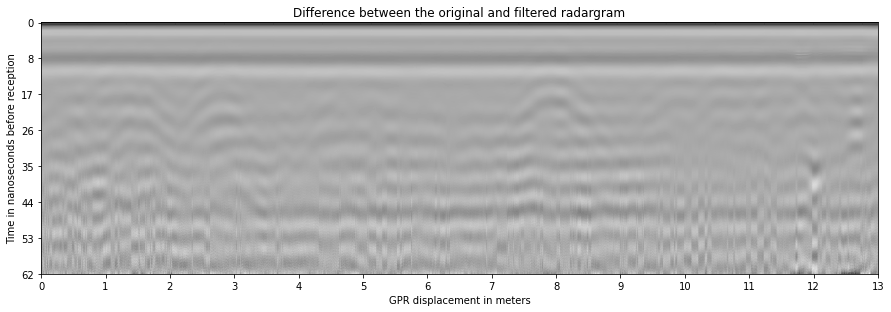

In [29]:
# Applies a vertical band-pass filter to the radargram and displays the changes

bs_vertical_filtered = filter_by_butterworth(bs, [vertical_low, vertical_high] , vertical_sample_rate, 'band', vertical=True, order=9)
plot_radargram(bs_vertical_filtered, "Band-passed radargram with a butterworth filter with cutoff frequencies of [" + str(horizontal_low) + ", " + str(horizontal_high) + "] m⁻1")
plot_radargram(bs, "Original radargram")
plot_radargram(np.abs(bs - bs_vertical_filtered), "Difference between the original and filtered radargram")

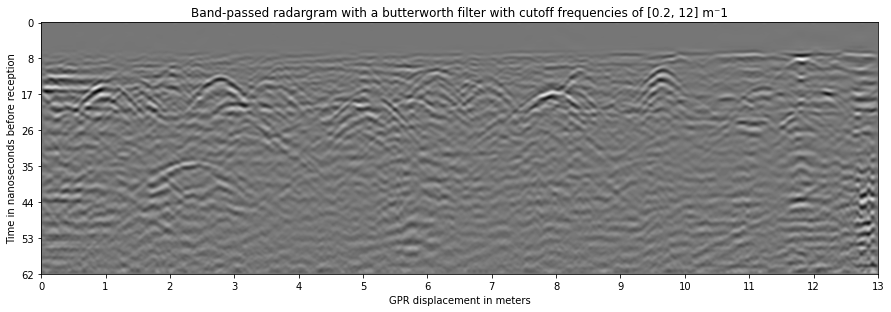

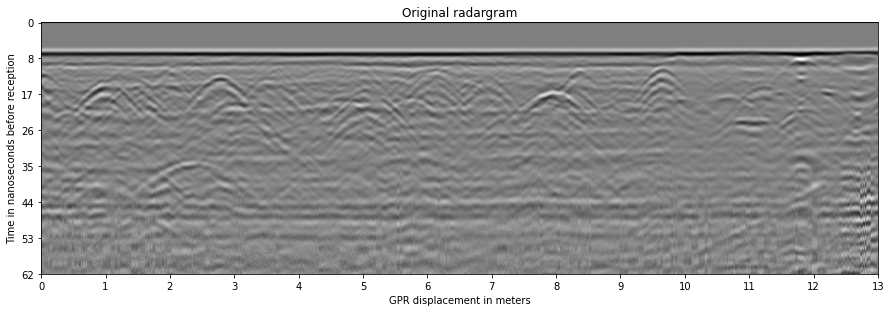

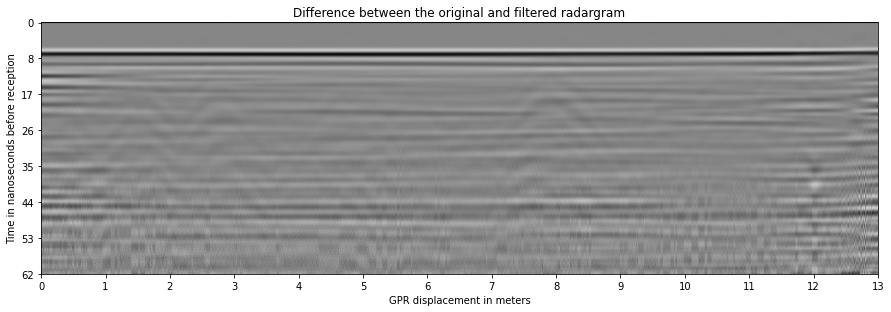

In [30]:
# Applies a horizontal band-pass filter to the vertical filtered radargram and displays the changes

bs_filtered = filter_by_butterworth(bs_vertical_filtered, [horizontal_low, horizontal_high], horizontal_sample_rate, 'band', vertical=False)
plot_radargram(bs_filtered, "Band-passed radargram with a butterworth filter with cutoff frequencies of [" + str(horizontal_low) + ", " + str(horizontal_high) + "] m⁻1")
plot_radargram(bs, "Original radargram")
plot_radargram(np.abs(bs - bs_filtered), "Difference between the original and filtered radargram")

### Analyse des résultats

Après l'application des deux filtres passe-bande, on remarque que l'onde direct et le ringing ont été éradiqué dans leur majorité, de plus, les artefacts en colonnes qui apparaissaient nettement sur le bas du radargramme ont été éconduit. Enfin, aussi à la fin du radargramme, on voit que le bruit a été étouffé.

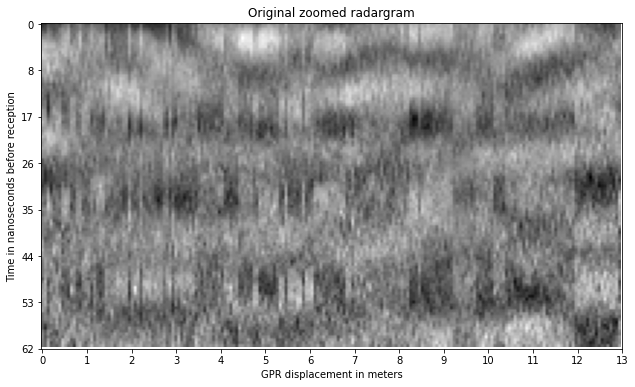

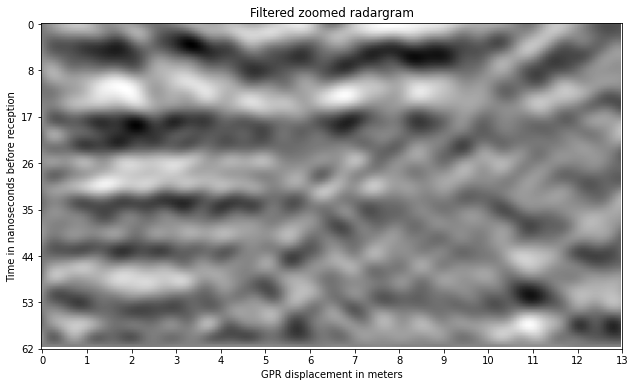

In [31]:
# Displays a zoom of the bottom-left of the filtered and original radargram  

plot_radargram(bs[400:, :200], "Original zoomed radargram")
plot_radargram(bs_filtered[400:, :200], "Filtered zoomed radargram")

## Comparaison entre la solution gardée et l'ancienne solution

Pour comparaison, on peut visualiser l'ancienne solution et la solution choisie. On remarque la différence sur le bas du radargramme où il y a plus de bruit sur l'ancienne solution.

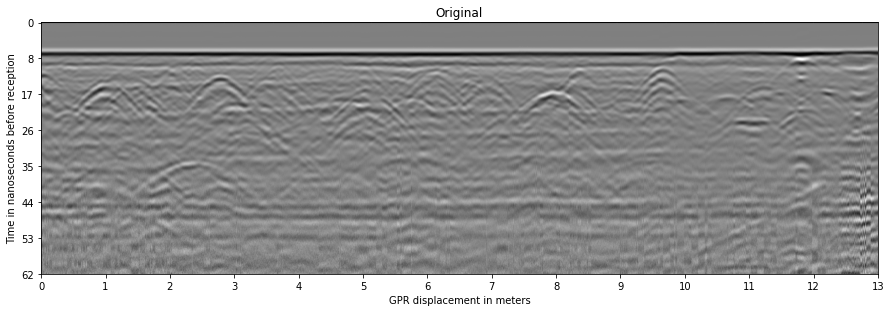

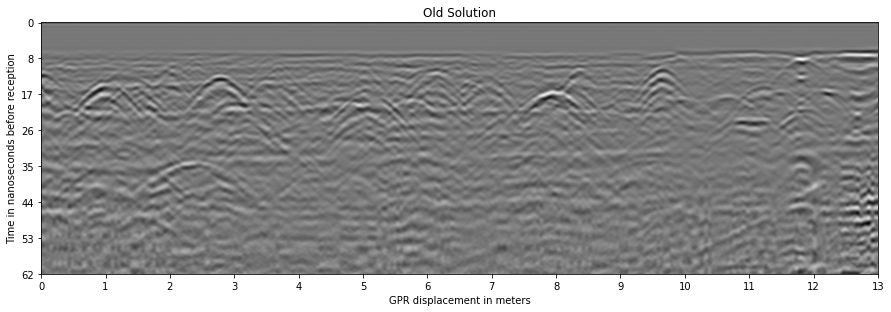

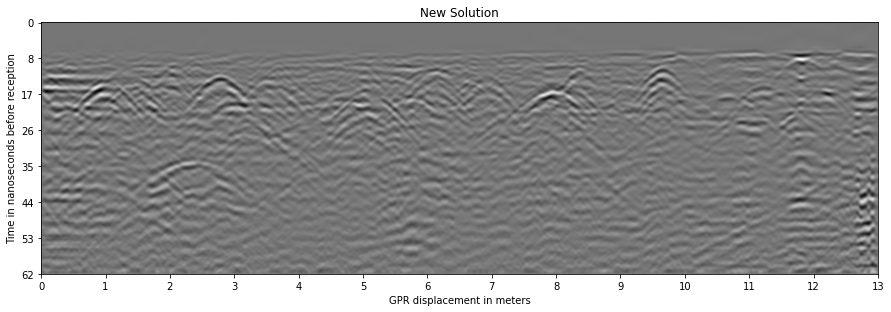

In [33]:
plot_radargram(bs, "Original")
plot_radargram(bs_filtered_old, "Old Solution")
plot_radargram(bs_filtered, "New Solution")